In [12]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = r'/Users/samyakjain/traffic-signs-data/train.p'
validation_file = r'/Users/samyakjain/traffic-signs-data/valid.p'
testing_file = r'/Users/samyakjain/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('Data loaded')


Data loaded


In [13]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


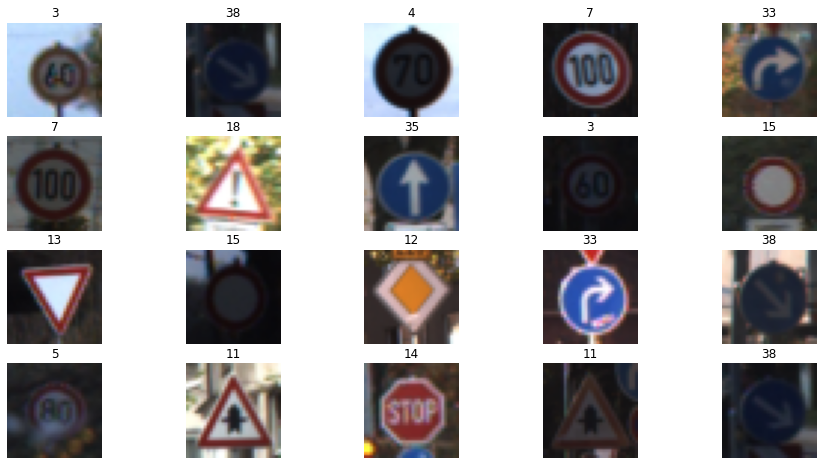

In [14]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# show image of 20 random data points
figs, axs = plt.subplots(4, 5, figsize = (16, 8))
figs.subplots_adjust(hspace = .2, wspace = .001)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

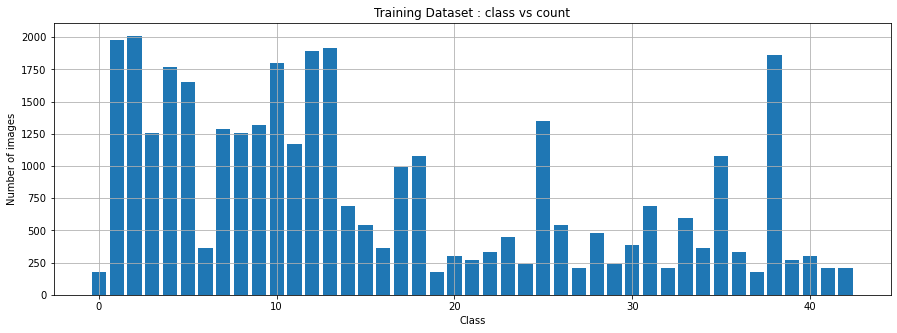

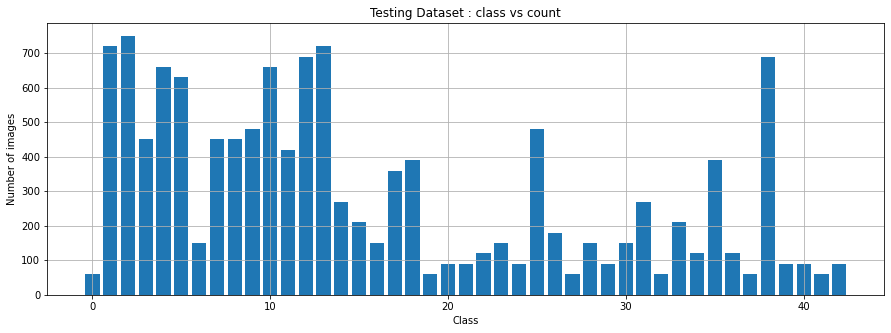

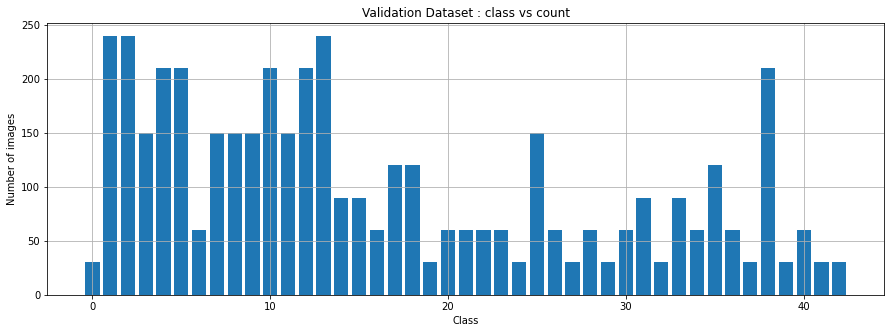

In [15]:
import numpy as np

train_class, train_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(train_class, train_counts)
plt.grid()
plt.title("Training Dataset : class vs count")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

test_class, test_counts = np.unique(y_test, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(test_class, test_counts)
plt.grid()
plt.title("Testing Dataset : class vs count")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

valid_class, valid_counts = np.unique(y_valid, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(valid_class, valid_counts)
plt.grid()
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.title("Validation Dataset : class vs count")
plt.show()


In [25]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include converting
### to grayscale, etc. Feel free to use as many code cells as needed.
### Define functions to be used for pre-processing, cleaning and augmenting the data
import cv2

def normalize(dataset):
    return dataset/128.0 - 1.0

def rgbtograyscale(dataset):
    return np.sum(dataset/3, axis = 3, keepdims = True)

def histogram_eq(dataset):
    hist_eq_dataset = []
    channels = np.shape(dataset[0])[2]
    for i in range(len(dataset)):
        img = dataset[i]
        for j in range(channels):
            img[:, :, j] = cv2.equalizeHist(img[:, :, j])
        hist_eq_dataset.append(img)
    return hist_eq_dataset

def rand_rotation(dataset):
    rand_rotation_dataset = []
    rows,cols = dataset[0].shape[:2]
    for i in range(len(dataset)):
        img = dataset[i]
        random_angle = 30.0*np.random.rand() - 15 # rotations are restricted to be within (-15, 15) degreees
        M = cv2.getRotationMatrix2D((cols/2,rows/2), random_angle, 1) 
        dst = cv2.warpAffine(img, M, (cols, rows))
        rand_rotation_dataset.append(dst)
    return rand_rotation_dataset

def rand_translation(dataset):
    rand_translation_dataset = []
    rows,cols = dataset[0].shape[:2]
    for i in range(len(dataset)):
        img = dataset[i]
        delx, dely = np.random.randint(-3, 3, 2)
        M = np.float32([[1, 0, delx],[0, 1, dely]])
        dst = cv2.warpAffine(img, M, (cols,rows))        
        rand_translation_dataset.append(dst)
    return rand_translation_dataset

def rand_zoom(dataset):
    rand_zoom_dataset = []
    rows,cols = dataset[0].shape[:2]
    for i in range(len(dataset)):
        img = dataset[i]
        px = np.random.randint(-2, 2) # transform limits
        pts1 = np.float32([[px,px],[rows-px,px],[px,cols-px],[rows-px,cols-px]]) # ending locations
        pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]]) # starting locations
        M = cv2.getPerspectiveTransform(pts1,pts2)
        dst = cv2.warpPerspective(img,M,(rows,cols))      
        rand_zoom_dataset.append(dst)
    return rand_zoom_dataset     

def augment_dataset(dataset, dataset_class, deficit, deficit_class):
# Note: even though there might be duplicates selected from the original X_train dataset
# in augment dataset, application of transformations like random rotation, histogram 
# equalization etc. will produce new features for the network which will help
# generalize the model.
    X_train_deficit = dataset[dataset_class == deficit_class]
    X_train_augment = []
    for i in range(deficit):
        index = random.randint(0, len(X_train_deficit) - 1)
        X_train_augment.append(X_train_deficit[index])
    return X_train_augment, deficit_class*np.ones(len(X_train_augment))


In [26]:
deficit_index = train_class[train_counts < 800] # This coincidentally is also the deficit class label
deficit_count = 800 - train_counts[deficit_index]
n_augment = np.sum(deficit_count)

print(deficit_count) # print the number of images to be added per class
print(deficit_index) # print the class of images to be added
print(n_augment) # print the total number of images to be added

X_train_augment = []
y_train_augment = []

for i in range(len(deficit_index)):
    augment_data, augment_class = augment_dataset(X_train, y_train, deficit_count[i], deficit_index[i])
    X_train_augment.extend(augment_data)
    y_train_augment.extend(augment_class)
    
print(len(X_train_augment)) # verify number of images in augment dataset matches with total number of images to be added


[620 440 110 260 440 620 500 530 470 350 560 260 590 320 560 410 110 590
 201 440 470 620 530 500 590 590]
[ 0  6 14 15 16 19 20 21 22 23 24 26 27 28 29 30 31 32 33 34 36 37 39 40
 41 42]
11681
11681


(34799, 32, 32, 3)
(11681, 32, 32, 3)
(34799,)
(11681,)


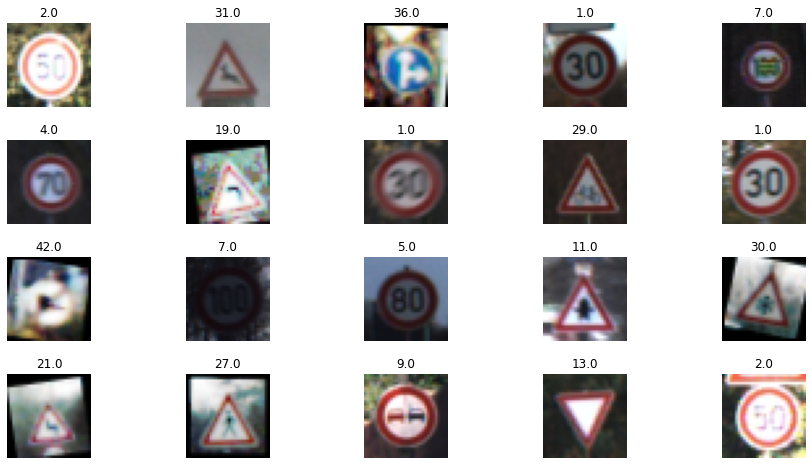

In [27]:

X_train_augment = np.array(X_train_augment) # convert to np array from list
y_train_augment = np.array(y_train_augment) # convert to np array from list

print(np.shape(X_train)) 
print(np.shape(X_train_augment))
print(np.shape(y_train))
print(np.shape(y_train_augment))

# Once we have a set of images selected from the original dataset for augmenting the training data, we apply
# various transformations like random rotation, translation, zoom and histogram equalization on the augment dataset.
# This augment dataset is then concatenated with the original dataset.

X_train = np.concatenate((X_train, rand_translation(rand_rotation(histogram_eq(rand_zoom(X_train_augment))))), axis = 0)
y_train = np.concatenate((y_train, y_train_augment), axis = 0)

# show image of 20 random data points
figs, axs = plt.subplots(4, 5, figsize = (16, 8))
figs.subplots_adjust(hspace = .4, wspace = .001)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train) - 1)
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

(46480, 32, 32, 3)
(46480,)


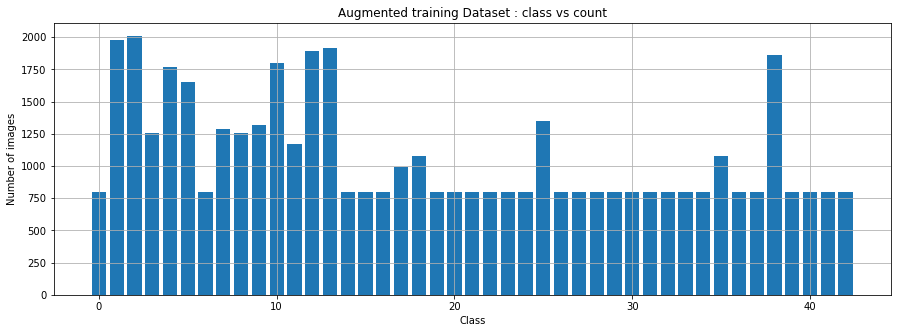

In [28]:
print(np.shape(X_train))
print(np.shape(y_train))

# plot distribution of augmented dataset
train_class, train_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(15, 5))
plt.bar(train_class, train_counts)
plt.grid()
plt.title("Augmented training Dataset : class vs count")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

(46480, 32, 32, 1)
(12630, 32, 32, 3)
(4410, 32, 32, 1)


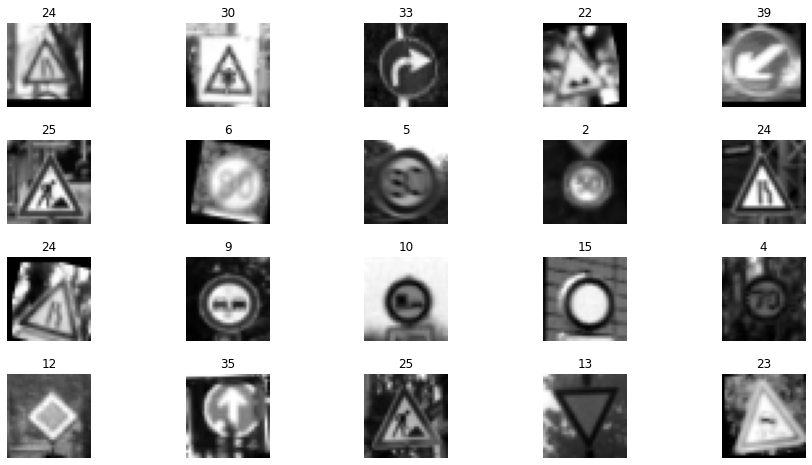

In [29]:
X_train = np.array(X_train) # convert to np array from list
X_valid = np.array(X_valid) # convert to np array from list
X_train = normalize(rgbtograyscale(X_train)) # normalize the dataset and convert to grayscale
X_valid = normalize(rgbtograyscale(X_valid)) # normalize the dataset and convert to grayscale

# verify whether the preprocessing is applied successfully to validation and training datasets
    
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_valid))

# show image of 20 random data points
figs, axs = plt.subplots(4, 5, figsize = (16, 8))
figs.subplots_adjust(hspace = .4, wspace = .001)
axs = axs.ravel()
for i in range(20):
    index = random.randint(0, len(X_train) - 1)
    image = X_train[index].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(int(y_train[index]))

In [30]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 60
BATCH_SIZE = 200

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolution. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = (5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Activation
    conv1 = tf.nn.relu(conv1)
                          
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
                   
    # Layer 2: Convolution. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation
    conv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    conv2 = flatten(conv2)
    
    # Dropout layer 1
    conv2 = tf.nn.dropout(conv2, 0.80)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fconnected1_w = tf.Variable(tf.truncated_normal([400, 120], mean = mu, stddev = sigma))
    fconnected1_b = tf.Variable(tf.zeros(120))
    fconnected_1 = tf.add(tf.matmul(conv2, fconnected1_w), fconnected1_b)
    
    # Activation.
    fconnected_1 = tf.nn.relu(fconnected_1)
    
    # Dropout layer 2
    fconnected_1 = tf.nn.dropout(fconnected_1, 0.75)                             
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fconnected2_w = tf.Variable(tf.truncated_normal([120, 84], mean = mu, stddev = sigma))
    fconnected2_b = tf.Variable(tf.zeros(84))
    fconnected_2 = tf.add(tf.matmul(fconnected_1, fconnected2_w), fconnected2_b)
    
    # Activation.
    fconnected_2 = tf.nn.relu(fconnected_2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fconnected3_w = tf.Variable(tf.truncated_normal([84, 43], mean = mu, stddev = sigma))
    fconnected3_b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fconnected_2, fconnected3_w), fconnected3_b)
    
    return logits

In [31]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_loss/float(num_examples), total_accuracy/float(num_examples)

train_loss_history = []
valid_loss_history = []

train_accuracy_history = []
valid_accuracy_history = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        valid_loss_history.append(validation_loss)
        valid_accuracy_history.append(validation_accuracy)
        train_loss, train_accuracy = evaluate(X_train, y_train)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Training Accuracy = {:.3f}".format(train_accuracy))
        print("Validation loss = {:.3f}".format(validation_loss))
        print("Training loss = {:.3f}".format(train_loss))
        
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.586
Training Accuracy = 0.570
Validation loss = 1.352
Training loss = 1.422

EPOCH 2 ...
Validation Accuracy = 0.736
Training Accuracy = 0.725
Validation loss = 0.840
Training loss = 0.911

EPOCH 3 ...
Validation Accuracy = 0.785
Training Accuracy = 0.789
Validation loss = 0.694
Training loss = 0.704

EPOCH 4 ...
Validation Accuracy = 0.820
Training Accuracy = 0.822
Validation loss = 0.571
Training loss = 0.575

EPOCH 5 ...
Validation Accuracy = 0.838
Training Accuracy = 0.847
Validation loss = 0.500
Training loss = 0.489

EPOCH 6 ...
Validation Accuracy = 0.864
Training Accuracy = 0.868
Validation loss = 0.438
Training loss = 0.430

EPOCH 7 ...
Validation Accuracy = 0.866
Training Accuracy = 0.878
Validation loss = 0.444
Training loss = 0.394

EPOCH 8 ...
Validation Accuracy = 0.873
Training Accuracy = 0.887
Validation loss = 0.419
Training loss = 0.358

EPOCH 9 ...
Validation Accuracy = 0.876
Training Accuracy = 0.894
Validation loss =

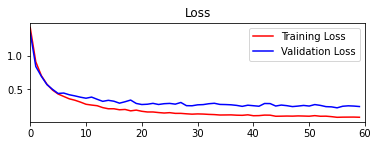

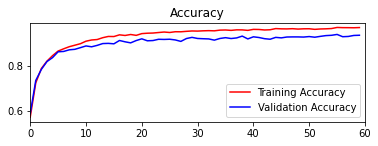

In [32]:
plt.figure()
loss_plot = plt.subplot(2,1,1)
loss_plot.set_title('Loss')
loss_plot.plot(train_loss_history, 'r', label='Training Loss')
loss_plot.plot(valid_loss_history, 'b', label='Validation Loss')
loss_plot.set_xlim([0, EPOCHS])
loss_plot.legend(loc = 1)

plt.figure()
accuracy_plot = plt.subplot(2,1,1)
accuracy_plot.set_title('Accuracy')
accuracy_plot.plot(train_accuracy_history, 'r', label='Training Accuracy')
accuracy_plot.plot(valid_accuracy_history, 'b', label='Validation Accuracy')
accuracy_plot.set_xlim([0, EPOCHS])
accuracy_plot.legend(loc = 4)

In [33]:

# Normalize and grayscale test dataset
X_test = normalize(rgbtograyscale(X_test))

In [41]:

#Run testing
with tf.Session() as sess:
    saver_new = tf.train.import_meta_graph('./lenet.meta')
    saver_new.restore(sess, "./lenet")
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.909


In [42]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy import misc
import glob

X_test_new = []
y_test_new = np.array([0, 14, 25, 4, 38])
path = r"C:\Users\VINOD\Google Drive\SDCND\CarND-Traffic-Sign-Classifier-Project\test_images_from_web/*.png"
for image_path in glob.glob(path):
    X_test_new.append(misc.imread(image_path))    

X_test_new = np.asarray(X_test_new)
print('Importing done...') 

# Apply normalization, rgb to grayscale conversion and other preprocessing steps
X_test_new = normalize(rgbtograyscale(X_test_new))
print()
print("Dimensions of test dataset:")
print(X_test_new.shape)

# show new test images
figs, axs = plt.subplots(1, 5, figsize = (6, 8))
figs.subplots_adjust(hspace = .4, wspace = .01)
axs = axs.ravel()
for i in range(5):
    image = X_test_new[i].squeeze()
    axs[i].axis('off')
    axs[i].imshow(image, cmap = 'gray')
    axs[i].set_title(int(y_test_new[i]))

Importing done...


AxisError: axis 3 is out of bounds for array of dimension 1

In [43]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#Run testing
with tf.Session() as sess:
    saver_new2 = tf.train.import_meta_graph('./lenet.meta')
    saver_new2.restore(sess, "./lenet")
    test_loss, test_accuracy = evaluate(X_test_new, y_test_new)
    softmax_prob = sess.run(tf.nn.softmax(logits), feed_dict={x: X_test_new})
    top5_prob = sess.run(tf.nn.top_k(softmax_prob, k = 5))
    
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

print("New Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet


ZeroDivisionError: float division by zero

IndexError: index 0 is out of bounds for axis 0 with size 0

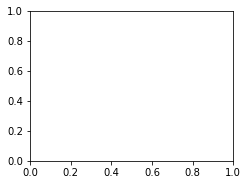

In [44]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
plt.figure(figsize = (8, 16))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(X_test_new[i].squeeze(), cmap = 'gray') 
    plt.title(y_test_new[i])
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top5_prob.values[i, :])
    plt.ylabel("Class")
    plt.xlabel("Probability")
    labs = top5_prob.indices[i]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()

In [45]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")